# Filmaffinity scrapper

## Description

My intention is to create a scrapper from all the way up of Filmaffinity. To gather the data I'll need to make my own scrapper. Mainly, the information I want to get is the following:

From films and series:

* Title
* Year
* Running time
* Country
* Director(s)
* Screenwriter(s)
* Cast
* Cinematography
* Producer(s)
* Genre(s)
* Synopsis
* Rating
* Pro rating
* Streaming services available

From reviews:

* Film
* Author number of reviews
* Author number of ratings
* Users agree with review
* Total rating average
* Date of review


## Constants

In [10]:
BASE_URL = "https://www.filmaffinity.com/es"

## Imports

In [11]:
import requests
import random
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
import os
from tqdm import tqdm

## Get links

### Manual test

First of all, what I need to do is to browse the Filmaffinity webpage in order to find from where I need to start scrapping the data.

I think the starting point should be the section "Top FA" where you can search applying different filters.

I realise that you can only select 10 different platforms to look up for films and series. However, in my opinion, this are where the vast majority of content is posted in. I've never hear 90% of names on this list.

It looks like the URL of the request needs to be something like the following:

https://www.filmaffinity.com/es/topgen.php?genres=&chv=0&orderby=rc&movietype=full%7C&country=&fromyear=1874&toyear=2025&ratingcount=0&runtimemin=0&runtimemax=7&platforms%5B%5D=8&platforms%5B%5D=119&platforms%5B%5D=1899&platforms%5B%5D=384&platforms%5B%5D=1773&platforms%5B%5D=337&platforms%5B%5D=149&platforms%5B%5D=350&platforms%5B%5D=63&platforms%5B%5D=1796

At the bottom of the page we can see a little arrow to load more films:

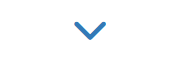

When you click the button Javascript makes a requests to an endpoint to get 30 more films. The response is not JSON but plain HTML that is later added to the current HTML section.
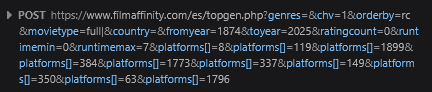

We can see that film are displayed inside an `ul` element and each film is an `li` element. Also, there is an special `li` with class="full-row" that seems like a delimiter each 10 films.

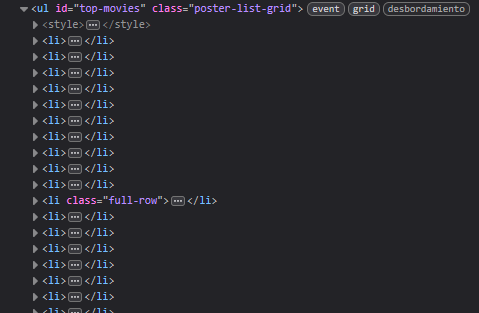

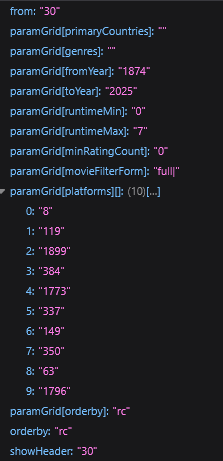

### Program

In [3]:
# First I make a request to the Top FA section

top_fa_request = requests.get(BASE_URL + "/topgen.php?genres=&chv=1&orderby=rc&movietype=full%7C&country=&fromyear=1874&toyear=2025&ratingcount=0&runtimemin=0&runtimemax=7&platforms%5B%5D=8&platforms%5B%5D=119&platforms%5B%5D=1899&platforms%5B%5D=384&platforms%5B%5D=1773&platforms%5B%5D=337&platforms%5B%5D=149&platforms%5B%5D=350&platforms%5B%5D=63&platforms%5B%5D=1796")

In [4]:
# I'll need to find how to iterate trough all of the films

top_fa_request = BeautifulSoup(top_fa_request.text)


In [5]:
# We get the ul element for the movies
list_top_fa = top_fa_request.find(id="top-movies")

list_top_fa

<ul class="poster-list-grid" id="top-movies">
<style>
:root{
    --numrows: 5;
    --percent: 19%;
}
    .poster-list-grid{ background: #FFFFFF !important; display: grid; grid-template-columns: repeat(var(--numrows), var(--percent)); grid-template-rows: auto; column-gap: 5px; row-gap: 10px; justify-items: center; align-items: center;  justify-content: center; list-style: none; padding: 0px; width: 100%;}
    .poster-list-grid .position-wrapper{ background: #333333; color: #FFFFFF; border-radius: 30px; width: 26px; height: 26px; border: 1px solid #FFFFFF; text-align: left; line-height: 24px; position: relative; z-index: 100; margin-bottom: -10px;}
    .poster-list-grid .position-wrapper .position-grid{ text-align: center; font-weight: bold; font-size: 14px;}
    .poster-list-grid img{ border-radius: 5px; box-shadow: 2px 3px 4px #bbbbbb; height: 221px ; width: 150px}
    .poster-list-grid .rating-wrapper { margin-top: -20px; justify-content: center; align-content: center; display: flex;}

From the hole list, we only need the link to the film. Therefore, we will save the links soo then we can request all the links in order to get the full information about each film.
As we only need the https://.../filmID.html we will get all the links, then we will apply a regex and finally deleting duplicates.

In [6]:
a_elements = list_top_fa.find_all('a')

link_list = [link.get('href') for link in a_elements]

film_links = []

for link in link_list:
    if re.findall("https://.*/film[0-9]*.html", link):
        film_links.append(link)

film_links = set(film_links)
display(film_links)
display(len(film_links))

{'https://www.filmaffinity.com/es/film160882.html',
 'https://www.filmaffinity.com/es/film161026.html',
 'https://www.filmaffinity.com/es/film226427.html',
 'https://www.filmaffinity.com/es/film261972.html',
 'https://www.filmaffinity.com/es/film314359.html',
 'https://www.filmaffinity.com/es/film372160.html',
 'https://www.filmaffinity.com/es/film392075.html',
 'https://www.filmaffinity.com/es/film395715.html',
 'https://www.filmaffinity.com/es/film419029.html',
 'https://www.filmaffinity.com/es/film444796.html',
 'https://www.filmaffinity.com/es/film459936.html',
 'https://www.filmaffinity.com/es/film494558.html',
 'https://www.filmaffinity.com/es/film495280.html',
 'https://www.filmaffinity.com/es/film499860.html',
 'https://www.filmaffinity.com/es/film516020.html',
 'https://www.filmaffinity.com/es/film536945.html',
 'https://www.filmaffinity.com/es/film575149.html',
 'https://www.filmaffinity.com/es/film594480.html',
 'https://www.filmaffinity.com/es/film607127.html',
 'https://ww

30

Now having the first 30, I would start looping in chunks of 30 films until I got less than 30 films
(I assume if I get less than 30 I reach the end)

In [7]:
# We try to get the first 30 after the initial 30's

current_film_number = 30
endpoint_topgen = BASE_URL + "/topgen.php?genres=&chv=1&orderby=rc&movietype=full%7C&country=&fromyear=1874&toyear=2025&ratingcount=0&runtimemin=0&runtimemax=7&platforms%5B%5D=8&platforms%5B%5D=119&platforms%5B%5D=1899&platforms%5B%5D=384&platforms%5B%5D=1773&platforms%5B%5D=337&platforms%5B%5D=149&platforms%5B%5D=350&platforms%5B%5D=63&platforms%5B%5D=1796"

request_data = {
    'from': str(current_film_number),
    'paramGrid[primaryCountries]': "",
    'paramGrid[genres]': "",
    'paramGrid[fromYear]': "1874",
    'paramGrid[toYear]': "2025",
    'paramGrid[runtimeMin]': "0",
    'paramGrid[runtimeMax]': "7",
    'paramGrid[minRatingCount]': "0",
    'paramGrid[movieFilterForm]': "full|",
    'paramGrid[platforms[]]': [8, 119, 1899, 384, 1773, 377, 149, 350, 63, 1796],
    'paramGrid[orderBy]': "rc" ,
    'orderBy': "rc",
    'showHeader': str(30)
}


chunk_30_films = requests.post(endpoint_topgen, data = request_data)

display(chunk_30_films.status_code)

200

In [8]:
chunk_30_films = BeautifulSoup(chunk_30_films.text)

In [9]:
links_chunk_30_films = [link.get('href') for link in chunk_30_films.find_all('a')]

film_list_30_chunk = []

for link in links_chunk_30_films:
    if re.findall("https://.*/film[0-9]*.html", link):
        film_list_30_chunk.append(link)

film_list_30_chunk = set(film_list_30_chunk)
display(film_list_30_chunk)
display(len(film_list_30_chunk))

{'https://www.filmaffinity.com/es/film112475.html',
 'https://www.filmaffinity.com/es/film121917.html',
 'https://www.filmaffinity.com/es/film152490.html',
 'https://www.filmaffinity.com/es/film186830.html',
 'https://www.filmaffinity.com/es/film256051.html',
 'https://www.filmaffinity.com/es/film265575.html',
 'https://www.filmaffinity.com/es/film304107.html',
 'https://www.filmaffinity.com/es/film309023.html',
 'https://www.filmaffinity.com/es/film333949.html',
 'https://www.filmaffinity.com/es/film358476.html',
 'https://www.filmaffinity.com/es/film370368.html',
 'https://www.filmaffinity.com/es/film412004.html',
 'https://www.filmaffinity.com/es/film479365.html',
 'https://www.filmaffinity.com/es/film514728.html',
 'https://www.filmaffinity.com/es/film518309.html',
 'https://www.filmaffinity.com/es/film539054.html',
 'https://www.filmaffinity.com/es/film568510.html',
 'https://www.filmaffinity.com/es/film576352.html',
 'https://www.filmaffinity.com/es/film598422.html',
 'https://ww

30

Now that we know how to get the next 30 films, we will start iterating over the entire film list (unless we get an status_code different from 200).

In [10]:
"""
with open('film_links.data', 'r') as file:
    film_links = set(file.read().splitlines())
"""


"\nwith open('film_links.data', 'r') as file:\n    film_links = set(file.read().splitlines())\n"

In [ ]:

current_film_number = len(film_links)
endpoint_topgen = BASE_URL + "/topgen.php?genres=&chv=1&orderby=rc&movietype=full%7C&country=&fromyear=1874&toyear=2025&ratingcount=0&runtimemin=0&runtimemax=7&platforms%5B%5D=8&platforms%5B%5D=119&platforms%5B%5D=1899&platforms%5B%5D=384&platforms%5B%5D=1773&platforms%5B%5D=337&platforms%5B%5D=149&platforms%5B%5D=350&platforms%5B%5D=63&platforms%5B%5D=1796"

while True:

    request_data = {
        'from': str(current_film_number),
        'paramGrid[primaryCountries]': "",
        'paramGrid[genres]': "",
        'paramGrid[fromYear]': "1874",
        'paramGrid[toYear]': "2025",
        'paramGrid[runtimeMin]': "0",
        'paramGrid[runtimeMax]': "7",
        'paramGrid[minRatingCount]': "0",
        'paramGrid[movieFilterForm]': "full|",
        'paramGrid[platforms[]]': [8, 119, 1899, 384, 1773, 377, 149, 350, 63, 1796],
        'paramGrid[orderBy]': "rc" ,
        'orderBy': "rc",
        'showHeader': str(current_film_number)
    }

    chunk_30_films = requests.post(endpoint_topgen, data = request_data)

    with open("temp.html", "w", encoding="utf-8") as temp_html:
        temp_html.write(chunk_30_films.text)

    if chunk_30_films.status_code != 200:
        print(f"Code {chunk_30_films.status_code}: aborting film scrapping at {current_film_number} films.")
        print("Waiting 5 seconds and retrying...")
        time.sleep(5)
        continue
    
    chunk_30_films = BeautifulSoup(chunk_30_films.text)

    links_chunk_30_films = [link.get('href') for link in chunk_30_films.find_all('a')]

    for link in links_chunk_30_films:
        if re.findall("https://.*/film[0-9]*.html", link):
            film_links.add(link)

    if current_film_number == len(film_links):
        print(f"No more films: {len(film_links)}")
        break

    # Save to disk
    with open('film_links.data', 'w') as file:
        file.write("\n".join(film_links))

    current_film_number = len(film_links)

    time.sleep(1)
    

No more films: 24349


^ Note: I had to run again the script and delete the "Less than 30 films chunk", because it seems that It can return less than 30 and still works.

## Get information

### Manual

First, we need to make a list of the information we could potencially get from every film:

* Year
* Duration
* Title
* Original title
* Movie types
* Country
* Director
* Screenwriter
* Cast
* Music
* Cinematography
* Producer
* Genre
* Synopsis
* Average rating
* Number of ratings
* Where to watch

There is more information, but I find this information more than enough.

In [12]:
# https://www.filmaffinity.com/es/film656153.html Schindler's List

film_request = requests.get('https://www.filmaffinity.com/es/film656153.html')
film_content = BeautifulSoup(film_request.text)

In [13]:
film_year = film_content.find('dd', itemprop='datePublished').get_text(strip=True)
film_duration = film_content.find('dd', itemprop='duration').get_text(strip=True).split()[0]
film_title = film_content.find('h1', id='main-title').find('span', itemprop='name').get_text(strip=True)
film_movie_types = [span_element.get_text(strip=True) for span_element in film_content.find('h1', id='main-title').find('span', class_='movie-type')]
film_country = film_content.find('dl', class_='movie-info').find('img', class_='nflag').get('alt')
film_director = [a_element.get_text(strip=True) for a_element in film_content.find('dd', class_='directors').find_all('a')]
film_cast = [div_element.get_text(strip=True) for div_element in film_content.find('dd', class_='card-cast-debug').find_all('div', class_='name')]
film_genre = [a_element.get_text(strip=True) for a_element in film_content.find('dd', class_='card-genres').find_all('a')]
film_synospsis = film_content.find('dd', itemprop="description").get_text(strip=True)
film_average_rating = film_content.find('div', id='movie-rat-avg').get_text(strip=True)
film_number_of_ratings = film_content.find('div', id='movie-count-rat').find('span', itemprop='ratingCount').get_text(strip=True)
film_pro_reviews_positive = film_content.find('div', class_='pro-reviews-chart-wrapper').find('div', class_='legend-wrapper').find_all('div', class_='leg')[0].get_text(strip=True)
film_pro_reviews_neutral  = film_content.find('div', class_='pro-reviews-chart-wrapper').find('div', class_='legend-wrapper').find_all('div', class_='leg')[1].get_text(strip=True)
film_pro_reviews_negative = film_content.find('div', class_='pro-reviews-chart-wrapper').find('div', class_='legend-wrapper').find_all('div', class_='leg')[2].get_text(strip=True)

film_where_to_watch_title = [title.get_text(strip=True) for title in film_content.find('div', id='stream-wrapper').find('div', class_='body').find_all('div', class_='sub-title')]
film_where_to_watch_sites = [[site.get('alt') for site in sites.find_all('img')] for sites in film_content.find('div', id='stream-wrapper').find('div', class_='body').find_all('div', class_='prov-offers-wrapper')]

film_where_to_watch_sus = []
film_where_to_watch_buy = []
film_where_to_watch_ren = []

for title, sites in zip(film_where_to_watch_title, film_where_to_watch_sites):
    if title.lower() == 'suscripción':
        film_where_to_watch_sus = sites
    elif title.lower() == 'compra':
        film_where_to_watch_buy = sites
    elif title.lower() == 'alquiler':
        film_where_to_watch_ren = sites
    else:
        pass

film_movie_info_title   = [title.get_text(strip=True) for title in film_content.find('dl', class_='movie-info').find_all('dt')]
film_movie_info_content = film_content.find('dl', class_='movie-info').find_all('dd')

for title, content in zip(film_movie_info_title, film_movie_info_content):
    title = title.lower()
    if title == 'título original':
        film_original_title = content.get_text(strip=True)
    elif title == 'guion':
        film_screenwriter = [a_element.get_text(strip=True) for a_element in content.find_all('a')]
    elif title == 'música':
        film_music = [a_element.get_text(strip=True) for a_element in content.find_all('a')]
    elif title == 'fotografía':
        film_cinematography = [a_element.get_text(strip=True) for a_element in content.find_all('a')]
    elif title == 'compañías':
        film_producer = [a_element.get_text(strip=True) for a_element in content.find_all('a')]
    else:
        pass


display(film_year)
display(film_duration)
display(film_title)
display(film_original_title)
display(film_movie_types)
display(film_country)
display(film_director)
display(film_screenwriter)
display(film_cast)
display(film_music)
display(film_cinematography)
display(film_producer)
display(film_genre)
display(film_synospsis)
display(film_average_rating)
display(film_number_of_ratings)
display(film_pro_reviews_positive)
display(film_pro_reviews_neutral)
display(film_pro_reviews_negative)
display(film_where_to_watch_sus)
display(film_where_to_watch_buy)
display(film_where_to_watch_ren)

'1993'

'195'

'La lista de Schindler'

"Schindler's List"

[]

'Estados Unidos'

['Steven Spielberg']

['Steven Zaillian', 'Thomas Keneally']

['Liam Neeson',
 'Ben Kingsley',
 'Ralph Fiennes',
 'Caroline Goodall',
 'Jonathan Sagall',
 'Embeth Davidtz',
 'Norbert Weisser',
 'Martin S. Bergmann',
 'Mark Ivanir',
 'Malgorzata Gebel',
 'Shmuel Levy',
 'Michael Schneider',
 'Joachim Paul Assböck']

['John Williams']

['Janusz Kaminski']

['Universal Pictures', 'Amblin Entertainment']

['Drama',
 'Nazismo',
 'Holocausto',
 'Basado en hechos reales',
 'II Guerra Mundial',
 'Película de culto']

'Oskar Schindler (Liam Neeson), un empresario alemán de gran talento para las relaciones públicas, busca ganarse la simpatía de los nazis de cara a su beneficio personal. Después de la invasión de Polonia por los alemanes en 1939, Schindler consigue, gracias a sus relaciones con los altos jerarcas nazis, la propiedad de una fábrica de Cracovia. Allí emplea a cientos de operarios judíos, cuya explotación le hace prosperar rápidamente, gracias sobre todo a su gerente Itzhak Stern (Ben Kingsley), también judío. Pero conforme la guerra avanza, Schindler y Stern comienzan ser conscientes de que a los judíos que contratan, los salvan de una muerte casi segura en el temible campo de concentración de Plaszow, que lidera el Comandante nazi Amon Goeth (Ralph Fiennes), un hombre cruel que disfruta ejecutando judíos. (FILMAFFINITY)'

'8,6'

'177.437'

'19'

'1'

'0'

['Movistar Plus+ Ficción Total ', 'Filmin', 'Movistar Plus+']

['Google Play Movies',
 'Apple TV',
 'Rakuten TV',
 'Microsoft Store',
 'Amazon Video']

['Google Play Movies',
 'Apple TV',
 'Rakuten TV',
 'Microsoft Store',
 'Amazon Video']

After a lot of effort trying to figure out how to get things like the screenwriters or the streaming services available, now I can iterate trough all the films that we have in our list.

### Program

In [30]:
film_links = ["https://www.filmaffinity.com/es/" + file_name for file_name in os.listdir('htmls_film_info')]
len(film_links)

24367

In [60]:

data_film = []
films_error = []


for link in tqdm(list(film_links)):
    
    film_id = str(link).split('/')[-1].split('.')[0]
    film_content = ""

    # Only request if not already downloaded
    if not os.path.exists(os.path.join(os.getcwd(), "htmls_film_info", film_id + ".html")):
        film_content_request = requests.get(link,
                                            headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)', 'Accept-Language': 'es-ES,es;q=0.8,en-US;q=0.5,en;q=0.3'}).text

        # Save html content on disk
        with open(f'htmls_film_info/{film_id}.html', 'w', encoding="utf-8") as file:
            file.write(film_content_request)

    # Si existe ahora mismo pasatelo
    else:
        with open(f'htmls_film_info/{film_id}.html', 'r', encoding='utf-8') as file:
            film_content_request = file.read()

    film_content = BeautifulSoup(film_content_request)

    h1_s = film_content.find_all("h1")

    for h1 in h1_s:
        # If too many request get a proxy and continue requesting films
        if h1.get_text() == "Too many requests":
            raise Exception
            r_proxy = random.choice(set_proxies)

            current_proxy = {"http": r_proxy, "https": r_proxy}

            print(f"INFO: Too many requests (proxy:{r_proxy})")
            
            film_content_request = requests.get(link,
                                            headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)', 'Accept-Language': 'es-ES,es;q=0.8,en-US;q=0.5,en;q=0.3'},
                                            proxies=current_proxy,)
 
            film_content_raw_request = film_content_request
            film_content_request = film_content_request.text

            with open(f'htmls_film_info/{film_id}.html', 'w', encoding="utf-8") as file:
                file.write(film_content_request)

            film_content = BeautifulSoup(film_content_request)

            with open('temp.html', "w") as temp_html:
                temp_html.write(film_content_request)

    try:

        if film_content.find('dd', itemprop='datePublished') != None:
            film_year = film_content.find('dd', itemprop='datePublished').get_text(strip=True)
        else:
            film_year = None
        
        if film_content.find('dd', itemprop='duration') != None:
            film_duration = film_content.find('dd', itemprop='duration').get_text(strip=True).split()[0]
        else:
            film_duration = None

        film_title = film_content.find('h1', id='main-title').find('span', itemprop='name').get_text(strip=True)
        film_movie_types = [span_element.get_text(strip=True) for span_element in film_content.find('h1', id='main-title').find('span', class_='movie-type')]
        film_country = film_content.find('dl', class_='movie-info').find('img', class_='nflag').get('alt')
        
        if film_content.find('dd', class_='directors') != None:
            film_director = [a_element.get_text(strip=True) for a_element in film_content.find('dd', class_='directors').find_all('a')]
        else:
            film_director = None
    
        if film_content.find('dd', class_='card-cast-debug') != None:
            film_cast = [div_element.get_text(strip=True) for div_element in film_content.find('dd', class_='card-cast-debug').find_all('div', class_='name')]
        elif film_content.find('dd', class_='card-cast') != None:
            film_cast = [span_element.get_text(strip=True) for span_element in film_content.find('dd', class_='card-cast').find_all('span', itemprop='name')]
        else:
            film_cast = None

        film_genre = [a_element.get_text(strip=True) for a_element in film_content.find('dd', class_='card-genres').find_all('a')]
        
        if film_content.find('dd', itemprop="description") != None:
            film_synospsis = film_content.find('dd', itemprop="description").get_text(strip=True)
        else:
            film_synospsis = None

        if film_content.find('div', id='movie-rat-avg') != None:
            film_average_rating = film_content.find('div', id='movie-rat-avg').get_text(strip=True)
        else:
            film_average_rating = None
        
        if film_content.find('div', id='movie-count-rat') != None:
            film_number_of_ratings = film_content.find('div', id='movie-count-rat').find('span', itemprop='ratingCount').get_text(strip=True)
        else:
            film_number_of_ratings = None
    
        if film_content.find('div', class_='pro-reviews-chart-wrapper') != None:
            film_pro_reviews_positive = film_content.find('div', class_='pro-reviews-chart-wrapper').find('div', class_='legend-wrapper').find_all('div', class_='leg')[0].get_text(strip=True)
            film_pro_reviews_neutral  = film_content.find('div', class_='pro-reviews-chart-wrapper').find('div', class_='legend-wrapper').find_all('div', class_='leg')[1].get_text(strip=True)
            film_pro_reviews_negative = film_content.find('div', class_='pro-reviews-chart-wrapper').find('div', class_='legend-wrapper').find_all('div', class_='leg')[2].get_text(strip=True)
        else:
            film_pro_reviews_positive = None
            film_pro_reviews_neutral  = None
            film_pro_reviews_negative = None

        film_where_to_watch_title = None
        film_where_to_watch_sites = None

        try:
            film_where_to_watch_title = [title.get_text(strip=True) for title in film_content.find('div', id='stream-wrapper').find('div', class_='body').find_all('div', class_='sub-title')]
            film_where_to_watch_sites = [[site.get('alt') for site in sites.find_all('img')] for sites in film_content.find('div', id='stream-wrapper').find('div', class_='body').find_all('div', class_='prov-offers-wrapper')]
        except Exception:
            pass

        film_where_to_watch_sus = []
        film_where_to_watch_buy = []
        film_where_to_watch_ren = []

        if film_where_to_watch_title and film_where_to_watch_sites:
            for title, sites in zip(film_where_to_watch_title, film_where_to_watch_sites):
                if title.lower() == 'suscripción':
                    film_where_to_watch_sus = sites
                elif title.lower() == 'compra':
                    film_where_to_watch_buy = sites
                elif title.lower() == 'alquiler':
                    film_where_to_watch_ren = sites
                else:
                    with open('where_to_watch.log', 'a', encoding='utf-8') as file:
                        file.write(f"{title}:{sites}\n")


        film_movie_info_title   = [title.get_text(strip=True) for title in film_content.find('dl', class_='movie-info').find_all('dt')]
        film_movie_info_content = film_content.find('dl', class_='movie-info').find_all('dd')

        film_original_title = None
        film_screenwriter   = None
        film_music          = None
        film_cinematography = None
        film_producer       = None

        for title, content in zip(film_movie_info_title, film_movie_info_content):
            title = title.lower()
            if title == 'título original':
                film_original_title = content.get_text(strip=True)
            elif title == 'guion':
                film_screenwriter = [a_element.get_text(strip=True) for a_element in content.find_all('a')]
            elif title == 'música':
                film_music = [a_element.get_text(strip=True) for a_element in content.find_all('a')]
            elif title == 'fotografía':
                film_cinematography = [a_element.get_text(strip=True) for a_element in content.find_all('a')]
            elif title == 'compañías':
                film_producer = [a_element.get_text(strip=True) for a_element in content.find_all('a')]
            else:
                pass

    except Exception as e:
        with open('errors.log', 'a') as log_file:
            log_file.write(f"{film_id}:exception: {e}\n")
        films_error.append(film_id)
        raise e

    row = {
        'film_id': film_id,
        'film_year': film_year,
        'film_duration': film_duration,
        'film_title': film_title,
        'film_original_title': film_original_title,
        'film_movie_types': film_movie_types,
        'film_country': film_country,
        'film_director': film_director,
        'film_screenwriter': film_screenwriter,
        'film_cast': film_cast,
        'film_music': film_music,
        'film_cinematography': film_cinematography,
        'film_producer': film_producer,
        'film_genre': film_genre,
        'film_synospsis': film_synospsis,
        'film_average_rating': film_average_rating,
        'film_number_of_ratings': film_number_of_ratings,
        'film_pro_reviews_positive': film_pro_reviews_positive,
        'film_pro_reviews_neutral': film_pro_reviews_neutral,
        'film_pro_reviews_negative': film_pro_reviews_negative,
        'film_where_to_watch_sus': film_where_to_watch_sus,
        'film_where_to_watch_buy': film_where_to_watch_buy,
        'film_where_to_watch_ren': film_where_to_watch_ren,
    }

    data_film.append(row)

pd.DataFrame(data=data_film).to_pickle('film_info.pkl')

100%|██████████| 24367/24367 [54:17<00:00,  7.48it/s]  


First I though that without any proxies or VPN's I could get all the information. I was completely wrong. Every 500 requests I get Error 429 AKA Too Many Requests

Then, I try many times to search for HTTPS/SSL free proxies, as I don't want to expend money on this. After a couple of days, I couldn't figure out how to use them, or I was using them wrong. But this didn't work at all.

The unique solution was to request to the server and wait until the "Too many requests" response. Therefore, I turn on the VPN (or change to another VPN server) and keep requesting the files.

It took me almost 3 days to get just 24367 films. This may seem a low quantity, but you need to have in mind that I still need to get all the user reviews.

Another downside was at the time of looping trough all the files and retrieving all the information I wanted, this take me too much time. More than I expected.

In [39]:
# We change the types and save the pandas DataFrame to pickle

film_df = None

try:
    film_df = pd.DataFrame(data=data_film)
except NameError:
    film_df = pd.read_pickle('film_info.pkl')

film_df['film_id'] = film_df['film_id'].astype('string')
film_df['film_year'] = film_df['film_year'].astype('int16')
film_df['film_duration'] = film_df['film_duration'].astype('int16')
film_df['film_title'] = film_df['film_title'].astype('string')
film_df['film_original_title'] = film_df['film_original_title'].astype('string')
film_df['film_movie_types'] = film_df['film_movie_types'].astype('object')
film_df['film_movie_types'] = film_df['film_movie_types'].apply(lambda x: [] if x == None else x)
film_df['film_country'] = film_df['film_country'].astype('string')
film_df['film_director'] = film_df['film_director'].astype('object')
film_df['film_director'] = film_df['film_director'].apply(lambda x: [] if x == None else x)
film_df['film_screenwriter'] = film_df['film_screenwriter'].astype('object')
film_df['film_screenwriter'] = film_df['film_screenwriter'].apply(lambda x: [] if x == None else x)
film_df['film_cast'] = film_df['film_cast'].astype('object')
film_df['film_cast'] = film_df['film_cast'].apply(lambda x: [] if x == None else x)
film_df['film_music'] = film_df['film_music'].astype('object')
film_df['film_music'] = film_df['film_music'].apply(lambda x: [] if x == None else x)
film_df['film_cinematography'] = film_df['film_cinematography'].astype('object')
film_df['film_cinematography'] = film_df['film_cinematography'].apply(lambda x: [] if x == None else x)
film_df['film_producer'] = film_df['film_producer'].astype('object')
film_df['film_producer'] = film_df['film_producer'].apply(lambda x: [] if x == None else x)
film_df['film_genre'] = film_df['film_genre'].astype('object')
film_df['film_genre'] = film_df['film_genre'].apply(lambda x: [] if x == None else x)
film_df['film_synospsis'] = film_df['film_synospsis'].astype('string')


film_df['film_average_rating'] = film_df['film_average_rating'].replace('None', pd.NA)
film_df['film_average_rating'] = film_df['film_average_rating'].apply(lambda x: str(x).replace(',', '.') if pd.notna(x) else x).astype('f4')
film_df['film_average_rating'] = film_df['film_average_rating'].fillna(0).astype('f4')
film_df['film_number_of_ratings'] = film_df['film_number_of_ratings'].replace('None', pd.NA)
film_df['film_number_of_ratings'] = film_df['film_number_of_ratings'].apply(lambda x: str(x).replace('.', '') if pd.notna(x) else x)
film_df['film_number_of_ratings'] = film_df['film_number_of_ratings'].fillna(0).astype('int')


film_df['film_pro_reviews_positive'] = film_df['film_pro_reviews_positive'].fillna(0).astype('int16')
film_df['film_pro_reviews_positive'] = film_df['film_pro_reviews_positive'].astype('int16')
film_df['film_pro_reviews_neutral'] = film_df['film_pro_reviews_neutral'].fillna(0).astype('int16')
film_df['film_pro_reviews_neutral'] = film_df['film_pro_reviews_neutral'].astype('int16')
film_df['film_pro_reviews_negative'] = film_df['film_pro_reviews_negative'].fillna(0).astype('int16')
film_df['film_pro_reviews_negative'] = film_df['film_pro_reviews_negative'].astype('int16')
film_df['film_where_to_watch_sus'] = film_df['film_where_to_watch_sus'].astype('object')
film_df['film_where_to_watch_buy'] = film_df['film_where_to_watch_buy'].astype('object')
film_df['film_where_to_watch_ren'] = film_df['film_where_to_watch_ren'].astype('object')


In [43]:
# Check that the columns are correct

film_df.head()

,film_id,film_year,film_duration,film_title,film_original_title,film_movie_types,film_country,film_director,film_screenwriter,film_cast,...,film_genre,film_synospsis,film_average_rating,film_number_of_ratings,film_pro_reviews_positive,film_pro_reviews_neutral,film_pro_reviews_negative,film_where_to_watch_sus,film_where_to_watch_buy,film_where_to_watch_ren
0,film100072,1993,123,¡Viven!,Alive!,[],Estados Unidos,[Frank Marshall],"[John Patrick Shanley, Piers Paul Read]","[Ethan Hawke, Josh Hamilton, Vincent Spano, Br...",...,"[Aventuras, Drama, Basado en hechos reales, Su...",Basada en una historia real. Narra la terrible...,6.8,33659,9,5,2,"[Netflix, Netflix Standard with Ads]","[Google Play Movies, Apple TV, Rakuten TV, Ama...","[Google Play Movies, Apple TV, Rakuten TV, Ama..."
1,film100083,2014,120,El caso sk1,L'affaire SK1,[],Francia,[Frédéric Tellier],"[David Oelhoffen, Frédéric Tellier]","[Raphaël Personnaz, Nathalie Baye, Olivier Gou...",...,"[Thriller, Basado en hechos reales, Crimen, Po...","París, 1991. Franck Magne es un joven inspecto...",5.9,2074,0,0,0,[Amazon Prime Video],"[Google Play Movies, Apple TV, Rakuten TV]","[Google Play Movies, Apple TV, Rakuten TV]"
2,film100152,2017,97,Soni,Soni,[],India,[Ivan Ayr],"[Ivan Ayr, Kislay Kislay]","[Kalpana Jha, Saloni Batra, Vikas Shukla, Geet...",...,[Drama],"Soni, una joven policía en Delhi, y su superin...",6.1,137,3,1,1,"[Netflix, Netflix Standard with Ads]",[],[]
3,film100160,2022,60,Dr. Stone: Ryusui,Dr. Stone: Ryusui,"[Episodio, Animación]",Japón,[Shûhei Matsushita],"[Yuichiro Kido, Riichirou Inagaki]",[],...,"[Animación, Acción, Fantástico, Ciencia ficció...","Especial de 1 hora para la televisión de ""Dr. ...",7.0,251,0,0,0,"[Netflix, Netflix Standard with Ads, Crunchyro...",[],[]
4,film100213,2019,92,El Príncipe,El príncipeaka,[],Chile,[Sebastián Muñoz],"[Luis Barrales, Sebastián Muñoz]","[Alfredo Castro, Juan Carlos Maldonado, Gastón...",...,"[Drama, Años 70, Homosexualidad, Drama carcela...","San Bernardo, Chile, justo antes que Allende a...",5.6,433,7,1,0,[Filmin],[],[Rakuten TV]


In [42]:
film_df.to_pickle('film_info.pkl')
film_df.to_csv('film_info.csv', sep=';')

## Get user reviews

### Manual

From the next image we can see that to get the second page of reviews for the film we only need to change the 1 before the filmID on the URL

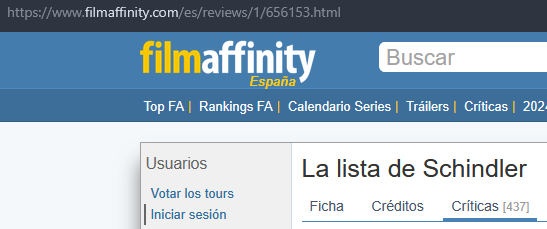

As today, there are 88 pages of reviews

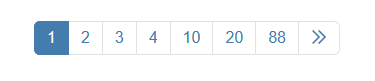

When we reach the page 89 we get a 404 error that the URL was not found on the server.

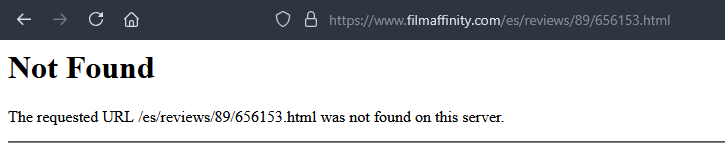

This should be easy to loop, we take a filmID, we loop from 1 to infinite until we get a 404 error, meaning that we have reached the limit of reviews.

In [14]:
user_review_test_req = requests.get('https://www.filmaffinity.com/es/reviews/1/656153.html')
user_review_test_req = BeautifulSoup(user_review_test_req.text)

We have the reviews on one page on the reviews-card-wrapper div, unless the third one that says something about video.

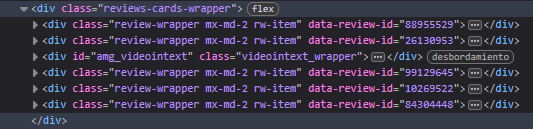

We can already see the review ID.

In [18]:
list_divs_reviews = user_review_test_req.find('div', class_='reviews-cards-wrapper')
list_divs_reviews = [user_review_div for user_review_div in list_divs_reviews.find_all('div', recursive=False)]
list_divs_reviews

[<div class="review-wrapper mx-md-2 rw-item" data-review-id="88955529">
 <div class="review-card" itemprop="review" itemscope="" itemtype="https://schema.org/Review">
 <meta content="Filmaffinity" itemprop="publisher"/>
 <div class="review-card-templates">
 <div aria-hidden="true" class="modal fade" id="reset-ratings-discard-changes-modal" tabindex="-1">
 <div class="modal-dialog modal-dialog-centered">
 <div class="modal-content">
 <div class="modal-header">
 <div class="modal-title fs-6"></div>
 <button aria-label="Close" class="btn-close" data-bs-dismiss="modal" type="button"></button>
 </div>
 <div class="modal-body">
 </div>
 <div class="modal-footer">
 <button class="btn btn-sm btn-secondary" data-bs-dismiss="modal" type="button">Cancelar</button>
 <button class="btn btn-sm btn-primary apply-modal" type="button">Ok</button>
 </div>
 </div>
 </div>
 </div>
 <div aria-hidden="true" class="modal fade" id="blog-ext-link-usercard" tabindex="-1">
 <div class="modal-dialog modal-dialog-

In [28]:
# We are going to take the first one and take the information we need.
review_0 = list_divs_reviews[0]
display(review_0)

review_id = review_0.find('div', class_="review-rate row").get('data-review-id')
author_id = review_0.find('div', class_="usercard-mini").get('data-user-id')
author_n_ratings = review_0.find('div', class_="hstack gap-3").find_all('a')[0].get_text(strip=True)
author_n_reviews = review_0.find('div', class_="hstack gap-3").find_all('a')[1].get_text(strip=True)
author_rating = review_0.find('div', class_="fa-user-rat-box not-me").get_text(strip=True)
author_review_date  = review_0.find('small', class_="rev-date").get_text()
author_review_title = review_0.find('div', class_="rev-title text-wrap").get_text()
author_users_useful = review_0.find('small', class_="rev-useful").find_all('b')[0].get_text()
author_users_useful_total = review_0.find('small', class_="rev-useful").find_all('b')[1].get_text()
author_review_desc  = review_0.find('div', itemprop="description").get_text(strip=True)
# author_review_spoiler = review_0.find('div', class_="spoiler-wrapper spoiler-text-hidden", itemprop="description").get_text()
# We have to check if there is spoiler

display(review_id)
display(author_id)
display(author_n_ratings)
display(author_n_reviews)
display(author_rating)
display(author_review_date)
display(author_review_title)
display(author_users_useful)
display(author_users_useful_total)
display(author_review_desc)
# display(author_review_spoiler)

<div class="review-wrapper mx-md-2 rw-item" data-review-id="88955529">
<div class="review-card" itemprop="review" itemscope="" itemtype="https://schema.org/Review">
<meta content="Filmaffinity" itemprop="publisher"/>
<div class="review-card-templates">
<div aria-hidden="true" class="modal fade" id="reset-ratings-discard-changes-modal" tabindex="-1">
<div class="modal-dialog modal-dialog-centered">
<div class="modal-content">
<div class="modal-header">
<div class="modal-title fs-6"></div>
<button aria-label="Close" class="btn-close" data-bs-dismiss="modal" type="button"></button>
</div>
<div class="modal-body">
</div>
<div class="modal-footer">
<button class="btn btn-sm btn-secondary" data-bs-dismiss="modal" type="button">Cancelar</button>
<button class="btn btn-sm btn-primary apply-modal" type="button">Ok</button>
</div>
</div>
</div>
</div>
<div aria-hidden="true" class="modal fade" id="blog-ext-link-usercard" tabindex="-1">
<div class="modal-dialog modal-dialog-centered">
<div class=

'88955529'

'967458'

'5.471'

'178'

'10'

'8 de julio de 2006'

'Esta lista es el bien absoluto, la vida más allá del abismo'

'419'

'468'

'¿ Cómo puede una niña pequeña perdida entre la multitud ejemplificar de una manera tan perfecta el puro horror ante la masacre ? Spielberg logró que el espectador se sintiera, al igual que Oskar Schindler en su caballo, abrumado al ver cómo una pequeña niña caminaba sola por el guetto en medio de la masacre, y con el paso del tiempo, dicha secuencia ha permanecido grabada a fuego en el subconsciente colectivo como una de esas imágenes de un poder visual único. Spielberg calló las bocas de aquellos que le tachaban de mero director de productos ultracomerciales con esta película necesaria, soberbia, hermosa, y demostrando a todo el mundo que si se pone serio, no pierde ni un ápice de calidad.Su origen judío y el nazismo han sido elementos que siempre han obsesionado al genio americano, y para comprobarlo sólo hay que ver la reciente Munich y la primera y tercera parte de Indiana Jones. Pero con esta película, Spielberg realizó su obra más catártica, el fin de una etapa en su carrera, y 

Now we know how to get all the necesary information about a review.

### Program